In [1]:
from datetime import date, datetime, timedelta 
import numpy as np 
import pandas as pd

import sys
sys.path.append('../utils')
import db

from keras.models import load_model
from sklearn import preprocessing

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
taskid = '{date:%Y%m%d-%H%M%S}'.format( date=datetime.now()) 
print(taskid)


20190805-150840


### Load Keras Model

In [3]:
# load model
model = load_model('TA model v2.h5')
# summarize model.
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 7)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 20)            2240      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 20)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 20)            3280      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 20)            0         
_______________________________________

## Get Stock Price

In [4]:
seq_length = 50

In [5]:
df_stock_price_all = db.show_stock_price()
df_stock_price_all = df_stock_price_all.sort_values(by=['stockcode','date'])

In [6]:
df_stock_price_all['stockcode'].unique()

array(['0005.HK', '0011.HK', '0023.HK', '0222.HK', '0416.HK', '0440.HK',
       '0626.HK'], dtype=object)

In [7]:
df_stock_price_all.tail()

,stockcode,date,open,high,low,close,adjclose,volume
2365,0626.HK,2019-07-30,3.27,3.27,3.27,3.27,3.27,78000.0
2366,0626.HK,2019-07-31,3.27,3.27,3.27,3.27,3.27,0.0
2367,0626.HK,2019-08-01,3.25,3.25,3.23,3.24,3.24,334000.0
2368,0626.HK,2019-08-02,3.21,3.23,3.21,3.21,3.21,232000.0
2369,0626.HK,2019-08-05,3.21,3.21,3.13,3.14,3.14,880000.0


In [8]:
# Create Empty Dataframe
df_stock_price = pd.DataFrame(columns=df_stock_price_all.columns.tolist()+['target'] )

# Calculate rolling average as target for each stock
for stock in df_stock_price_all.stockcode.unique():
    df_tmp = df_stock_price_all[df_stock_price_all['stockcode']==stock].copy()
    df_tmp['target'] = df_tmp['adjclose'].rolling(window=5).mean()
    df_stock_price = df_stock_price.append(df_tmp)

df_stock_price = df_stock_price[df_stock_price.target.notnull()]

In [12]:
list(df_stock_price[df_stock_price.stockcode == '0005.HK'].adjclose)[-1]

61.0

In [9]:
df_stock_price

,stockcode,date,open,high,low,close,adjclose,volume,target
4,0005.HK,2018-01-08,80.50,80.80,80.05,80.50,73.561,21354440.0,73.8442
5,0005.HK,2018-01-09,80.20,81.10,80.15,80.95,73.972,20734671.0,73.7802
6,0005.HK,2018-01-10,80.95,82.40,80.95,82.10,75.023,70547231.0,73.9904
7,0005.HK,2018-01-11,83.95,84.30,83.55,84.05,76.805,54006301.0,74.6392
8,0005.HK,2018-01-12,84.20,84.40,83.25,83.70,76.485,29034596.0,75.1692
9,0005.HK,2018-01-15,84.90,84.95,83.80,84.10,76.851,44252539.0,75.8272
10,0005.HK,2018-01-16,84.30,84.80,84.00,84.80,77.491,27343839.0,76.5310
11,0005.HK,2018-01-17,84.95,85.10,84.70,85.05,77.719,38403425.0,77.0702
12,0005.HK,2018-01-18,86.00,86.00,85.05,85.45,78.085,35014328.0,77.3262
13,0005.HK,2018-01-19,85.60,85.95,85.05,85.40,78.039,25476127.0,77.6370


In [36]:
categorical_cols = ['stockcode','date']
numerical_cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'target']

In [31]:
def normalize_df(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df[numerical_cols] = min_max_scaler.fit_transform(df[numerical_cols])
    return df

In [32]:
def get_df_pred(stock):
    
    num_of_sample = 100
    
    X = np.zeros((num_of_sample + 1, seq_length, len(numerical_cols)))
    y = np.zeros((num_of_sample + 1))
    D = []
    
    # Pick A Random Stock 
    df = df_stock_price[df_stock_price['stockcode']==stock].copy()
    df = normalize_df(df)
    
    print('df:',len(df))
    
    # Get X, y of the stock
    n = 0
    while n < num_of_sample:
        remain = num_of_sample - n 
        X[n] = df[numerical_cols][-seq_length-remain:-remain].values
        y[n] = list(df['target'])[-remain]
        D.append(list(df['date'])[-remain])
        n = n + 1
    
    X[num_of_sample] = df[numerical_cols][-seq_length:].values
    y[num_of_sample] = np.nan
    
    D.append(D[-1] + timedelta(days=1))
    return X, y, D

df: 383


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


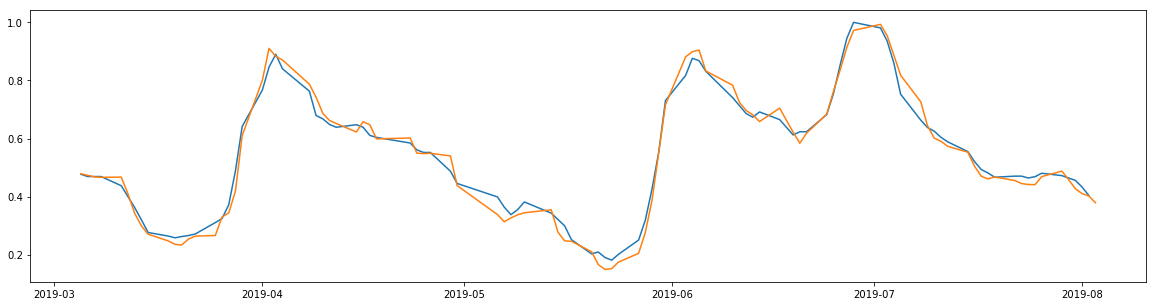

In [41]:
X_Ori, y_Ori, X_Date = get_df_pred('3866.HK')
y_pred = model.predict(X_Ori)

plt.figure(figsize=(20,5))
plt.plot(X_Date, y_Ori)
plt.plot(X_Date,y_pred)


In [50]:
percent_chg = (float(y_pred[-1]) - y_Ori[-2]) * 100 / y_Ori[-2]
str(percent_chg)+'%'

'-6.216534497391951%'

0.3790919780731201

In [24]:
stocks_latest_update = []
for stock in df_stock_price['stockcode'].unique():
    latest_update = max(df_stock_price[df_stock_price.stockcode==stock].date).strftime('%Y-%m-%d')
    stocks_latest_update.append([stock, latest_update])


NameError: name 'y_pred' is not defined